In [1]:
import pickle
import torch
import numpy as np
import sbibm
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from pathlib import Path

from torch.distributions.transforms import AffineTransform, identity_transform

from utils import (
    lan_likelihood_on_batch, 
    apply_lower_bound_given_mask, 
    huber_loss, 
    mean_squared_error, 
    decode_1d_to_2d_x
)

import lanfactory

# Plotting settings
plt.style.use('../plotting_settings.mplstyle')
# Colorblind color palette
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# Fix seed for figures.
seed = 223174 #torch.randint(1000000, (1,))
torch.manual_seed(seed)
print(f"seed {seed}")

BASE_DIR = Path.cwd().parent.parent.as_posix()
data_folder = BASE_DIR + "/data/"
model_folder = BASE_DIR + "/notebooks/mnle-lan-comparison/models/"
save_folder = BASE_DIR + "/data/results/"

# Set log-likelihood lower bound for all methods, use 1e-7 as the highest bound used during training (e.g., for 10^11 budget LANs).
l_lower_bound = 1e-7
LL_LOWER_BOUND = np.log(l_lower_bound)

seed 223174


In [2]:
task = sbibm.get_task("ddm")
prior = task.get_prior_dist()
simulator = task.get_simulator(seed=seed) # Passing the seed to Julia.

In [3]:
# Load pre-simulated training data
with open(data_folder + "ddm_training_and_test_data_10mio.p", "rb") as fh:
    theta, x_1d, xos_1d, thos = pickle.load(fh).values()

num_simulations = 10_000

theta = theta[:num_simulations]

# encode x as (time, choice)
x = torch.zeros((num_simulations, 2))
x[:, 0] = abs(x_1d[:num_simulations, 0])
x[x_1d[:num_simulations, 0] > 0, 1] = 1

# encode xos as (time, choice)
xos = torch.zeros((xos_1d.shape[0], 2))
xos[:, 0] = abs(xos_1d[:, 0])
xos[xos_1d[:, 0] > 0, 1] = 1

## Calculate metrics from pre-trained models

In [4]:
# load one pre-trained model
with open(model_folder + "mnle_n100000_0_0.p", "rb") as fh:
    mnle = pickle.load(fh)

## Show single likelihood

In [5]:
# Sample one parameter from the prior for a likelihood example.
theta_o = prior.sample((1,))
theta_o

tensor([[-0.1089,  1.0866,  0.6434,  1.3179]])

In [6]:
# RT range
test_tmax = 5
# Number of test points
ntest = 1000
rs = torch.cat((torch.linspace(test_tmax, l_lower_bound, ntest//2), 
           torch.linspace(l_lower_bound, test_tmax, ntest//2))).reshape(-1, 1)
cs = torch.cat((torch.zeros(ntest//2), 
           torch.ones(ntest//2))).reshape(-1, 1)

test_x = torch.hstack((rs, cs))
test_rts = torch.linspace(-test_tmax, test_tmax, ntest)

In [7]:
# get NLE synthetic likelihood for each data point with fixed theta.
lps_mnle = mnle.log_prob(test_x, theta_o.repeat(test_x.shape[0], 1)).detach()

# from analytical likelihood
lps_true = torch.tensor([task.get_log_likelihood(theta_o, d.reshape(-1, 1), l_lower_bound=l_lower_bound) 
                     for d in test_rts])


/home/janfb/.local/lib/python3.7/site-packages/julia/core.py:691: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  FutureWarning,


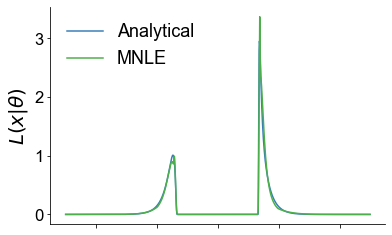

In [8]:
import matplotlib.pyplot as plt
import numpy as np

labels = ["Analytical", 
          "MNLE", 
         ]
xticks = np.arange(-4, 5, 2)

plt.plot(test_rts, lps_true.exp(), label="Analytical L", c=colors[0]);
plt.plot(test_rts, lps_mnle.exp(), label="MNLE", ls="-", c=colors[2]);
plt.ylabel(r"$L(x | \theta)$");
plt.legend(labels)
plt.xticks(xticks, []);

### Systematic comparison

In [9]:
def score_mnle(path_to_model, num_observations, num_thetas_per_observation):

    # load model
    with open(path_to_model, "rb") as fh:
        mnle, *_ = pickle.load(fh).values()

    errors = []
    for idx in range(num_observations):
        # Sample test thetas from prior.
#         test_theta = test_thetas[idx]
        test_theta = thos[idx][:num_thetas_per_observation]
        xoi = xos_1d[idx].reshape(-1, 1)
        rts = abs(xoi)
        

        # Evaluate
        lps_mnle_i = mnle.log_prob(xos[idx].repeat(num_thetas_per_observation, 1), test_theta).detach()

        # apply lower bound and ndt constraint.
        rt_smaller_ndt = rts.repeat(1, test_theta.shape[0]) < test_theta[:, -1] 
        below_bound = lps_mnle_i < LL_LOWER_BOUND

        mask = torch.logical_or(rt_smaller_ndt, below_bound).squeeze()
        
        lps_mnle_i = apply_lower_bound_given_mask(lps_mnle_i, mask, ll_lower_bound=LL_LOWER_BOUND)
        lps_true_i = task.get_log_likelihood(test_theta, data=xoi.reshape(1, -1), l_lower_bound=np.exp(LL_LOWER_BOUND))

        # Score
        errors.append([
            huber_loss(lps_mnle_i, lps_true_i),
            huber_loss(lps_mnle_i.exp(), lps_true_i.exp()),
            mean_squared_error(lps_mnle_i, lps_true_i),
            mean_squared_error(lps_mnle_i.exp(), lps_true_i.exp()),
            ])

    return np.array(errors)

def score_lan(network_file_path, num_observations, num_thetas_per_observation, apply_transform=True):

    # get network config from model folder.
    with open(list(network_file_path.parent.glob("*_network_config.pickle"))[0], "rb") as fh:
        network_config = pickle.load(fh)

    # load model
    network = lanfactory.trainers.LoadTorchMLPInfer(model_file_path = network_file_path,
                                                network_config = network_config,
                                                input_dim = 6)  # 4 params plus 2 data dims
    
    # Transform scales param "a" by 0.5
    if apply_transform:
        transform = AffineTransform(torch.zeros(1, 4), torch.tensor([[1.0, 0.5, 1.0, 1.0]]))
    else:
        transform = identity_transform

    errors = []
    for idx in range(num_observations):
        # Sample test thetas from prior.
        test_theta = thos[idx][:num_thetas_per_observation]
        xoi = xos_1d[idx].reshape(-1, 1)
        
        # Evaluate
        lps_lankde_i = lan_likelihood_on_batch(xoi, test_theta, network, transform)
        assert lps_lankde_i.shape == torch.Size((1, test_theta.shape[0]))
        lps_lankde_i = lps_lankde_i.squeeze()
        
        # apply lower bound and ndt constraint.
        rt_smaller_ndt = abs(xoi).repeat(1, test_theta.shape[0]) < test_theta[:, -1] 
        is_below_bound = lps_lankde_i < LL_LOWER_BOUND

        mask = torch.logical_or(rt_smaller_ndt, is_below_bound).squeeze()
        
        lps_lankde_i = apply_lower_bound_given_mask(lps_lankde_i, mask, ll_lower_bound=LL_LOWER_BOUND)
        
        # get true likelihood.
        lps_true_i = task.get_log_likelihood(test_theta, data=xoi, l_lower_bound=np.exp(LL_LOWER_BOUND))

        # Score
        errors.append([
            huber_loss(lps_lankde_i, lps_true_i),
            huber_loss(lps_lankde_i.exp(), lps_true_i.exp()),
            mean_squared_error(lps_lankde_i, lps_true_i),
            mean_squared_error(lps_lankde_i.exp(), lps_true_i.exp()),
            ])

    return np.array(errors)


In [10]:
# mimick the MCMC setting: xo is fixed, thetas are scored with loss
num_observations = 100
num_thetas_per_observation = 1000

# first sample observations xo
xos_1d = simulator(prior.sample((num_observations,)))
xos = decode_1d_to_2d_x(xos_1d)
test_thetas = []
for xoi in xos:
    # Sample test thetas from prior.
    test_thetas.append(prior.sample((num_thetas_per_observation,)))

test_thetas = torch.stack(test_thetas)

### Calculate metrics for every trained model (~5min per budget)

### LAN metrics

In [36]:
num_workers = 1
num_observations = 100
num_thetas_per_observation = 1000

# set budget for which to calculate
budget = "10_11"
apply_transform = True
model_folder = Path.cwd() / f"data/torch_models/ddm_{budget}/"  # Pathlib object
model_paths = list(model_folder.glob(f"*_ddm_{budget}_torch_state_dict.pt"))
# model_paths

results = Parallel(n_jobs=num_workers)(
    delayed(score_lan)(model_path, num_observations, num_thetas_per_observation, apply_transform=apply_transform) for model_path in model_paths
)

with open(save_folder + f"lan_likelihood_metrics_n{budget}.p", "wb") as fh:
    pickle.dump(dict(
        results=np.array(results),
        num_observations=num_observations, 
        num_thetas_per_observation=num_thetas_per_observation, 
        model_paths=model_paths), fh)

tanh
tanh
linear


/home/janfb/qode/mnle-for-ddms/notebooks/mnle-lan-comparison/utils.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)


### MNLE metrics

In [13]:
num_workers = 1
num_observations = 100
num_thetas_per_observation = 1000

# set budget for which to calculate
budget = 100000
model_folder = Path.cwd() / "models"  # Pathlib object
model_paths = list(model_folder.glob(f"*n{budget}_new_*"))
# model_paths

results = Parallel(n_jobs=num_workers)(
    delayed(score_mnle)(model_path, num_observations, num_thetas_per_observation) for model_path in model_paths
)

with open(save_folder + f"mnle_likelihood_metrics_n{budget}_ndtconstraint.p", "wb") as fh:
    pickle.dump(dict(
        results=np.array(results),
        num_observations=num_observations, 
        num_thetas_per_observation=num_thetas_per_observation, 
        model_paths=model_paths), fh)


In [57]:
results_100k.mean(1)

array([[0.33886357, 0.00471742, 1.37038892, 0.00849783],
       [0.17797235, 0.00352453, 0.79786177, 0.00713414],
       [0.10571926, 0.00287443, 0.5589707 , 0.00570055],
       [0.20408907, 0.00320583, 0.83832776, 0.00563083],
       [0.31548262, 0.0042433 , 1.29035181, 0.00829172],
       [0.27528113, 0.00336926, 1.08154797, 0.00567311],
       [0.1997302 , 0.00325653, 0.76880135, 0.00565367],
       [0.23982392, 0.00433638, 0.89913997, 0.00851325],
       [0.14401046, 0.00265949, 0.60789334, 0.00448723],
       [0.14414509, 0.0027533 , 0.58983412, 0.00470648]])

In [14]:
with open(save_folder + "mnle_likelihood_metrics_n10000.p", "rb") as fh:
    results_10k, num_observations, num_thetas_per_observation, model_paths = pickle.load(fh).values()

with open(save_folder + "mnle_likelihood_metrics_n100000_ndtconstraint.p", "rb") as fh:
    results_100k, num_observations, num_thetas_per_observation, model_paths = pickle.load(fh).values()

with open(save_folder + "mnle_likelihood_metrics_n200000.p", "rb") as fh:
    results_200k, num_observations, num_thetas_per_observation, model_paths = pickle.load(fh).values()

with open(save_folder + "mnle_likelihood_metrics_n1000000.p", "rb") as fh:
    results_1000k, num_observations, num_thetas_per_observation, model_paths = pickle.load(fh).values()

with open(save_folder + "lan_likelihood_metrics_n10_4.p", "rb") as fh:
    results_10k_lan, num_observations, num_thetas_per_observation, model_paths = pickle.load(fh).values()

with open(save_folder + "lan_likelihood_metrics_n10_5_ours.p", "rb") as fh:
    results_100k_lan, num_observations, num_thetas_per_observation, model_paths = pickle.load(fh).values()
    
with open(save_folder + "lan_likelihood_metrics_n10_5_^2^3.p", "rb") as fh:
    results_100k_lan_2_3, num_observations, num_thetas_per_observation, model_paths = pickle.load(fh).values()

with open(save_folder + "lan_likelihood_metrics_n10_6.p", "rb") as fh:
    results_1000k_lan, num_observations, num_thetas_per_observation, model_paths = pickle.load(fh).values()

with open(save_folder + "lan_likelihood_metrics_n10_8_ours.p", "rb") as fh:
    results_100000k_lan, num_observations, num_thetas_per_observation, model_paths = pickle.load(fh).values()

with open(save_folder + "lan_likelihood_metrics_n10_7.p", "rb") as fh:
    results_10000k_lan, num_observations, num_thetas_per_observation, model_paths = pickle.load(fh).values()

with open(save_folder + "lan_likelihood_metrics_n10_11.p", "rb") as fh:
    results_10_11_lan, num_observations, num_thetas_per_observation, model_paths = pickle.load(fh).values()


In [15]:
metrics = []
metrics_lan = []

for ii in range(4):
    metrics.append(np.vstack((results_10k.mean(1)[:, ii], results_100k.mean(1)[:, ii], results_1000k.mean(1)[:10, ii])).T)
    metrics_lan.append(np.vstack((results_10k_lan.mean(1)[:, ii], results_100k_lan.mean(1)[:, ii], 
        results_1000k_lan.mean(1)[:, ii], 
        # results_100000k_lan.mean(1)[:, ii]
        )).T)

metrics = np.array(metrics)
metrics_lan = np.array(metrics_lan)

In [16]:
metrics.mean(1), metrics_lan.mean(1), metrics.shape

(array([[9.29757440e-01, 2.14511766e-01, 1.36688913e-01],
        [1.60344044e-02, 3.49404598e-03, 1.64021046e-03],
        [5.47505700e+00, 8.80311774e-01, 6.17124857e-01],
        [3.41200810e-02, 6.42888147e-03, 3.18347416e-03]]),
 array([[ 2.27115991,  1.38028175,  1.34301968],
        [ 0.08996776,  0.02004324,  0.02092244],
        [18.83398216, 12.27979372, 12.06176269],
        [ 0.18547468,  0.04109973,  0.04182352]]),
 (4, 10, 3))

### Simple comparison plot

<ErrorbarContainer object of 3 artists>

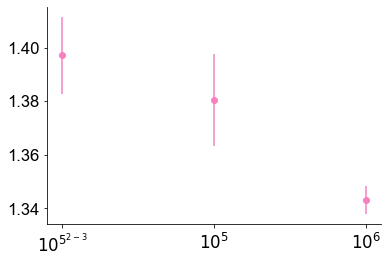

In [109]:
idx = 0
plt.errorbar([r"$10^{5^{2-3}}$"], results_100k_lan_2_3.mean(1).mean(0)[idx], 
             results_100k_lan_2_3.mean(1).std(0)[idx] / np.sqrt(10), marker="o",
             color=colors[3])
plt.errorbar([r"$10^{5}$"], results_100k_lan.mean(1).mean(0)[idx], 
             results_100k_lan.mean(1).std(0)[idx] / np.sqrt(10), marker="o",
             color=colors[3])
plt.errorbar([r"$10^{6}$"], results_1000k_lan.mean(1).mean(0)[idx], 
             results_100000k_lan.mean(1).std(0)[idx] / np.sqrt(10), marker="o",
             color=colors[3])

NameError: name 'metrics' is not defined

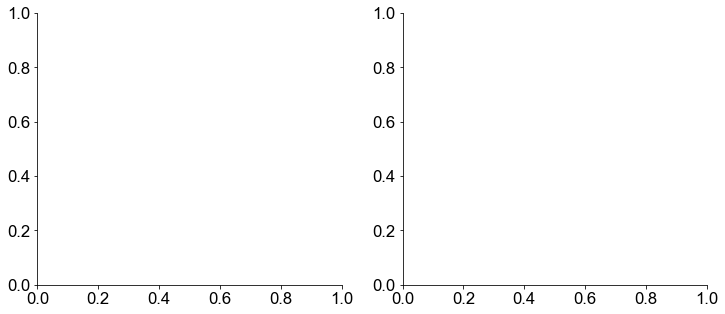

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
# labels = ["Huber loss (log)", "Huber loss", "MSE (log)", "MSE"]
labels = ["Huber loss (log)", "MSE (log)"]
budgets = [r"$10^4$", r"$10^5$", r"$10^6$", r"$10^8$"]
axidx = 0
for idx, m in enumerate(metrics):
    if idx in [0, 2]:
        plt.sca(ax[axidx])
#         plt.errorbar(budgets[:-1], m.mean(0), m.std(0)/np.sqrt(m.shape[0]), label="MNLE", color=colors[2])
#         plt.errorbar(budgets[:-1], metrics_lan[idx].mean(0), metrics_lan[idx].std(0)/np.sqrt(metrics_lan[idx].shape[0]), label="LAN", color=colors[1])
        plt.plot([r"$10^{5}$"], results_100k_lan.mean(1).mean(0)[idx], color=colors[1], marker="+")
        plt.plot([r"$10^{5-other}$"], results_100k_lan_2_3.mean(1).mean(0)[idx], color=colors[3], marker="+")
        # plt.plot([r"$10^{8}$"], results_100000k_lan.mean(1).mean(0)[idx], color=colors[1], marker="^")
#         plt.plot([r"$10^{11}$"], results_10_11_lan.mean(1).mean(0)[idx], color=colors[1], marker="*")
        plt.ylabel(labels[axidx])
        plt.legend()
        plt.xlabel("budget")
        axidx += 1
plt.tight_layout()

## Comparison to the old LAN implementation

In [18]:
from tensorflow import keras

In [52]:
# network trained on KDE likelihood for 4-param ddm
lan_kde_path = "../../data/pretrained-models/model_final_ddm.h5"
lan_kde = keras.models.load_model(lan_kde_path, compile=False)

net = lan_kde.predict_on_batch

# pass this to batch predict function:
transform = AffineTransform(torch.zeros(1, 4), torch.tensor([[1.0, 0.5, 1.0, 1.0]]))
test_theta = thos[0][:100]
old = lan_likelihood_on_batch(xos_1d[:1], test_theta, net, transform).squeeze()

In [54]:
# predict the same with the new one
model_folder = Path.cwd() / f"data/torch_models/ddm_{budget}/"  # Pathlib object
model_paths = list(model_folder.glob(f"*_ddm_{budget}_torch_state_dict.pt"))
network_file_path = model_paths[0]

with open(list(network_file_path.parent.glob("*_network_config.pickle"))[0], "rb") as fh:
        network_config = pickle.load(fh)

# load model
network = lanfactory.trainers.LoadTorchMLPInfer(model_file_path = network_file_path,
                                            network_config = network_config,
                                            input_dim = 6)  # 4 params plus 2 data dims
new = lan_likelihood_on_batch(xos_1d[:1], test_theta, network, transform).squeeze()

tanh
tanh
linear


/home/janfb/qode/mnle-for-ddms/notebooks/mnle-lan-comparison/utils.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)


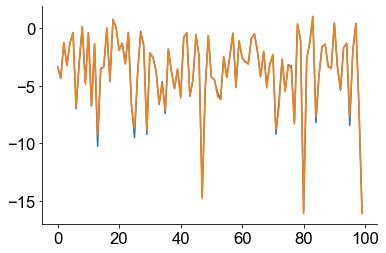

In [56]:
plt.plot(old)
plt.plot(new)